In [1]:
import numpy as np
import csv
from tqdm import tqdm
import base64
from io import BytesIO
import requests
import io
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras import models
from keras.layers import Input,Dense, Embedding, LSTM, SpatialDropout1D,Bidirectional
from keras.layers.merge import concatenate
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
import tensorflow as tf
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.regularizers import L1L2
from keras.regularizers import Regularizer
from keras.layers.normalization import BatchNormalization
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [3]:
# Username of your GitHub account
username = ''

# Personal Access Token (PAO) from your GitHub account
token = ''

# Creates a re-usable session object with your creds in-built
github_session = requests.Session()
github_session.auth = (username, token)


In [4]:
url = 'https://raw.githubusercontent.com/OmdenaAI/WeoWater/main/task-3-wrangling-preprocessing/All_merged/All_data_sources_merged_updated.csv'
download = github_session.get(url).content #Reading and downloading the data
data = pd.read_csv(io.StringIO(download.decode('utf-8'))) #Converting the data into a pd dataframe

#Extract instagram data from all dataseources
ig_data = data.loc[data['data source']=='Instagram']
ig_data.to_csv('ig_data.csv')

In [5]:
ig_data = pd.read_csv('ig_data.csv') 

In [6]:
ig_data.head(5)

,Unnamed: 0,Id,title,time,keywords,data source,category,country,source URL,body,language
0,4216,1.790000e+16,NaN,2021-06-17T14:49:15+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CQOakCZHpB2/,“Absence the highest form of presence”. #absen...,English
1,4217,1.790000e+16,NaN,2021-06-01T20:45:52+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPl2p5LBGVa/,Hearing aid design has come a very long way. W...,English
2,4218,1.790000e+16,NaN,2021-06-01T19:30:47+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPluDpMNFss/,Happy #PrideMonth from BAHA Irish Whiskey. Be ...,English
3,4219,1.790000e+16,NaN,2021-06-01T19:05:43+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlrHFjgNKf/,Figuring out these crazy hands 😆\n\n#babiesofi...,English
4,4220,1.790000e+16,NaN,2021-06-01T18:24:14+0000,NaN,Instagram,none,NaN,https://www.instagram.com/p/CPlmch8HzKT/,I am THRILLED to share these pictures with you...,English


In [7]:
ig_data.shape

(1633, 11)

In [8]:
ig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1633 non-null   int64  
 1   Id           1633 non-null   float64
 2   title        0 non-null      float64
 3   time         1609 non-null   object 
 4   keywords     0 non-null      float64
 5   data source  1633 non-null   object 
 6   category     1633 non-null   object 
 7   country      0 non-null      float64
 8   source URL   1633 non-null   object 
 9   body         1633 non-null   object 
 10  language     1633 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 140.5+ KB


In [9]:
drop_columns = ['Unnamed: 0','title', 'time', 'keywords', 'data source', 'country', 'source URL', 'language', 'Id']
ig_data_clean = ig_data.drop(columns=drop_columns,axis=1)

In [10]:
ig_data_clean.head(5)

,category,body
0,none,“Absence the highest form of presence”. #absen...
1,none,Hearing aid design has come a very long way. W...
2,none,Happy #PrideMonth from BAHA Irish Whiskey. Be ...
3,none,Figuring out these crazy hands 😆\n\n#babiesofi...
4,none,I am THRILLED to share these pictures with you...


In [11]:
def preprocess(article):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - removes any single character tokens
    Parameters
    ----------
        message : The text message to be preprocessed
    Returns
    -------
        text: The preprocessed text
    """ 
    # Lowercase the article
    text = article.lower()
    # Replace URLs with a space in the message
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub('\$[a-zA-Z0-9]*', ' ', text)
    text = re.sub('\@[a-zA-Z0-9]*', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    
    return text
        
# Process for all messages
preprocessed = [preprocess(posts) for posts in tqdm(ig_data_clean['body'])]

100%|██████████| 1633/1633 [00:00<00:00, 24597.68it/s]


In [12]:
ig_data_clean['Cleaned_body']= preprocessed

In [13]:
ig_data_clean.head(5)

,category,body,Cleaned_body
0,none,“Absence the highest form of presence”. #absen...,absence the highest form of presence absence p...
1,none,Hearing aid design has come a very long way. W...,hearing aid design has come very long way with...
2,none,Happy #PrideMonth from BAHA Irish Whiskey. Be ...,happy pridemonth from baha irish whiskey be wh...
3,none,Figuring out these crazy hands 😆\n\n#babiesofi...,figuring out these crazy hands babiesofinstagr...
4,none,I am THRILLED to share these pictures with you...,am thrilled to share these pictures with you t...


**Class balancing for category column**

In [14]:
ig_data_clean.category.value_counts()

none       1138
flood       388
drought     107
Name: category, dtype: int64

In [15]:
ig_data_drought = ig_data_clean[ig_data_clean.category == 'drought']
ig_data_drought.shape

(107, 3)

In [16]:
ig_data_none = ig_data_clean[ig_data_clean.category == 'none']
ig_data_none.shape

(1138, 3)

In [17]:
df_drought = shuffle(ig_data_drought)
df_none = shuffle(ig_data_none)

In [18]:
ig_train_d= df_drought.head(77)
ig_train_d.shape

(77, 3)

In [19]:
ig_train_n= df_none.head(77)
ig_train_n.shape

(77, 3)

In [20]:
ig_test_d= df_drought.tail(30)
ig_test_d.shape

(30, 3)

In [21]:
ig_test_n= df_none.tail(30)
ig_test_n.shape

(30, 3)

In [22]:
#concatenating
ig_train =pd.concat([ig_train_d,ig_train_n], ignore_index=True)
ig_train = shuffle(ig_train)
ig_train.shape

(154, 3)

In [23]:
ig_train.category.value_counts()

none       77
drought    77
Name: category, dtype: int64

In [24]:
#concatenating
ig_test =pd.concat([ig_test_d,ig_test_n], ignore_index=True)
ig_test = shuffle(ig_test)
ig_test.shape

(60, 3)

In [25]:
#changing the type from object to category
ig_train['category']=ig_train['category'].astype('category')
ig_test['category']=ig_test['category'].astype('category')

In [26]:
# Get the numerical ids of column label
numerical_ids_train = ig_train.category.cat.codes
numerical_ids_test = ig_test.category.cat.codes

# Print initial shape
print(numerical_ids_train.shape)
print(numerical_ids_test.shape)

(154,)
(60,)


In [27]:
le = LabelEncoder()
Y = le.fit_transform(ig_train['category'].values)
Y_test = le.transform(ig_test['category'].values)
len(le.classes_)

2

In [28]:
# One-hot encode the indexes
Y = to_categorical(numerical_ids_train)
Y_test = to_categorical(numerical_ids_test)

# Check the new shape of the variable
print(Y.shape)
print(Y_test.shape)

# Print the first 5 rows
print(Y[:5])

(154, 2)
(60, 2)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


**NLP Modelling**

**fit_on_texts:** Updates internal vocabulary based on a list of texts. This method creates the vocabulary index based on word frequency. So if you give it something like, "The cat sat on the mat." It will create a dictionary s.t. word_index["the"] = 1; word_index["cat"] = 2 it is word -> index dictionary so every word gets a unique integer value. 0 is reserved for padding. So lower integer means more frequent word (often the first few are stop words because they appear a lot).


**texts_to_sequences:** Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. Nothing more, nothing less, certainly no magic involved.

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(ig_train.Cleaned_body)
# Create the (X, Y) variables
X = tokenizer.texts_to_sequences(ig_train.Cleaned_body)
X = pad_sequences(X, maxlen=20)
#Y = to_categorical(ig_train.category)
# Print the shapes
print(X.shape)
print(Y.shape)

(154, 20)
(154, 2)


In [30]:
X_test = tokenizer.texts_to_sequences(ig_test.Cleaned_body)
X_test = pad_sequences(X_test, maxlen=20)
#Y_test = to_categorical(ig_test.category)
print(X_test.shape)
print(Y_test.shape)

(60, 20)
(60, 2)


In [31]:
import pickle
with open("tokenizer_drought.pkl", 'wb') as file:
    pickle.dump(tokenizer, file, protocol=pickle.HIGHEST_PROTOCOL)
with open("label_encoder_drought.pkl", 'wb') as file:
    pickle.dump(le, file, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
MAX_SEQUENCE_LENGTH = 100
MAX_NB_WORDS = 4000
EMBEDDING_DIM = 300
num_lstm = np.random.randint(175, 275)
num_dense = np.random.randint(100, 150)
rate_drop_lstm = 0.15 + np.random.rand() * 0.25
rate_drop_dense = 0.15 + np.random.rand() * 0.25

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3803 unique tokens.


In [33]:
EMBEDDING_FILE= '/content/gdrive/MyDrive/GoogleNews-vectors-negative300.bin.gz'

In [34]:
from gensim.models import KeyedVectors

print('Indexing word vectors')
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE,binary=True)
print('Found %s word vectors of word2vec' % len(word2vec.vocab))

print('Preparing embedding matrix')

nb_words = min(MAX_NB_WORDS, len(word_index))+1

embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if word in word2vec.vocab:
        embedding_matrix[i] = word2vec.word_vec(word)
print('Null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

Indexing word vectors
Found 3000000 word vectors of word2vec
Preparing embedding matrix
Null word embeddings: 1154


In [35]:
import numpy as np
np.save('embedding_matrix_drought.npy' , embedding_matrix)

In [36]:
from keras.optimizers import SGD,Adam
opt = SGD(learning_rate=0.01)
opt1= Adam(learning_rate=0.0001) 

In [37]:
model= Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(LSTM(num_lstm, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))
model.add(Dense(32,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer=opt1,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          1141200   
_________________________________________________________________
lstm (LSTM)                  (None, 224)               470400    
_________________________________________________________________
dense (Dense)                (None, 32)                7200      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 1,618,866
Trainable params: 477,666
Non-trainable params: 1,141,200
_________________________________________________________________


In [38]:
epochs= 8
batch_size= 12

history= model.fit(X,Y,epochs=epochs,batch_size=batch_size,validation_split=0.1)

Epoch 1/8
12/12 [==============================] - 29s 221ms/step - loss: 0.6887 - accuracy: 0.5022 - val_loss: 0.6881 - val_accuracy: 0.6875
Epoch 2/8
12/12 [==============================] - 1s 94ms/step - loss: 0.6556 - accuracy: 0.8300 - val_loss: 0.6719 - val_accuracy: 0.6875
Epoch 3/8
12/12 [==============================] - 1s 90ms/step - loss: 0.6201 - accuracy: 0.8662 - val_loss: 0.6536 - val_accuracy: 0.7500
Epoch 4/8
12/12 [==============================] - 1s 85ms/step - loss: 0.5838 - accuracy: 0.8575 - val_loss: 0.6327 - val_accuracy: 0.8125
Epoch 5/8
12/12 [==============================] - 1s 97ms/step - loss: 0.5486 - accuracy: 0.9007 - val_loss: 0.6055 - val_accuracy: 0.8125
Epoch 6/8
12/12 [==============================] - 1s 89ms/step - loss: 0.5152 - accuracy: 0.9347 - val_loss: 0.5677 - val_accuracy: 0.8750
Epoch 7/8
12/12 [==============================] - 1s 91ms/step - loss: 0.4407 - accuracy: 0.9376 - val_loss: 0.5078 - val_accuracy: 0.8125
Epoch 8/8
12/12 [=

Text(0.5, 1.0, 'Loss')

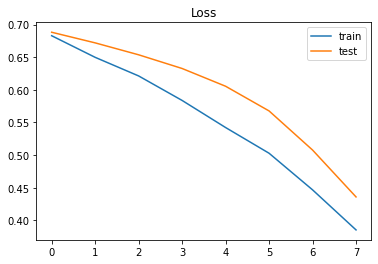

In [39]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Accuracy')

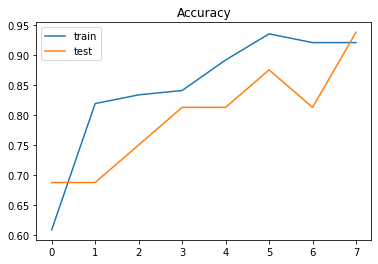

In [40]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

**Predicting Data**

In [41]:
y_pred = model.predict(X_test)

In [42]:
import numpy as np
y_pred=np.round(y_pred)

In [43]:
y_pred = np.argmax(y_pred, axis=-1)

In [44]:
y_test = np.argmax(Y_test, axis=-1)

In [45]:
y_pred

array([0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0])

In [46]:
# Accuracy
print(accuracy_score(y_test, y_pred))

0.8833333333333333


In [47]:
lab_names = ['drought','none']
print(classification_report(y_test, y_pred, target_names=lab_names))

              precision    recall  f1-score   support

     drought       0.85      0.93      0.89        30
        none       0.93      0.83      0.88        30

    accuracy                           0.88        60
   macro avg       0.89      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



In [48]:
print(precision_score(y_test, y_pred, average=None))
print(recall_score(y_test, y_pred, average=None))
print(f1_score(y_test, y_pred, average=None))

[0.84848485 0.92592593]
[0.93333333 0.83333333]
[0.88888889 0.87719298]


In [49]:
model.save('LSTMClassifier_with_ig_drought.h5')